# Propensity Score Matching: EPC and MSM for Haringey LAD

In this notebook we present the steps made to "merge" the EPC data and the MSM population.


## Initialisation

### Import necessary modules

In [1]:
import pandas as pd
import zipfile
import os
from causalinference import CausalModel
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from random import choices
%matplotlib inline

### Import data

#### Import EPC data

In [2]:
ladcd = 'E09000014' # local authority for testing: Haringey

epc_zip_file = zipfile.ZipFile(os.path.join('data', 'eps_england_oa.zip'))
epc_file = ".".join([ladcd, 'csv'])
epc_df = pd.read_csv(epc_zip_file.open(epc_file))
epc_df.rename({"LC4402_C_TENHUK11": "tenure"}, axis=1, inplace=True)
epc_df.head()

,Area,FLOOR_AREA,LC4404_C_ROOMS,MAINHEAT_DESCRIPTION,ACCOM_AGE,tenure,LC4402_C_TYPACCOM
0,E00010316,1,3,"Boiler and radiators, mains gas",4,5,5
1,E00010336,3,2,"Boiler and radiators, mains gas",1,5,5
2,E00010168,1,1,"Room heaters, electric",1,6,5
3,E00009985,2,4,"Boiler and radiators, mains gas",1,6,5
4,E00010505,3,4,Portable electric heaters assumed for most rooms,1,1,4


#### Import MSM data

In [3]:
msm_zip_file = zipfile.ZipFile(os.path.join('data', 'msm_england.zip'))
msm_file = "_".join(['msm_england/ass_hh', ladcd, 'OA11_2020.csv'])
msm_df = pd.read_csv(msm_zip_file.open(msm_file))
msm_df.head()

,HID,Area,LC4402_C_TYPACCOM,QS420_CELL,LC4402_C_TENHUK11,LC4408_C_AHTHUK11,CommunalSize,LC4404_C_SIZHUK11,LC4404_C_ROOMS,LC4405EW_C_BEDROOMS,LC4408EW_C_PPBROOMHEW11,LC4402_C_CENHEATHUK11,LC4605_C_NSSEC,LC4202_C_ETHHUK11,LC4202_C_CARSNO,HRPID,FILLED
0,0.0,E00010088,3.0,-2.0,3.0,3.0,-2.0,2.0,4.0,2.0,-1.0,2.0,2.0,2.0,2.0,254841.0,True
1,1.0,E00010222,2.0,-2.0,5.0,1.0,-2.0,1.0,3.0,1.0,-1.0,2.0,9.0,7.0,1.0,269214.0,True
2,2.0,E00010300,5.0,-2.0,6.0,2.0,-2.0,4.0,6.0,4.0,-1.0,2.0,4.0,4.0,1.0,206340.0,False
3,3.0,E00010394,-2.0,-2.0,-1.0,-1.0,-2.0,0.0,1.0,1.0,-1.0,2.0,-1.0,-1.0,1.0,-1.0,False
4,4.0,E00010345,5.0,-2.0,6.0,3.0,-2.0,2.0,4.0,1.0,-1.0,2.0,5.0,4.0,1.0,258891.0,True


##### MSM data: transform tenure values 2 and 3 to 1

In the EPC data the tenure values 2 (`Owned outright`) and 3 (`Owned with a mortgage or loan or shared ownership`) are aggregated in the value 1 (`Owned: Total`).

In [4]:
df_col = 'tenure'
msm_df[df_col] = msm_df.LC4402_C_TENHUK11.copy()
msm_df.loc[(msm_df[df_col] == 2), df_col] = 1 # 2 = Owned outright
msm_df.loc[(msm_df[df_col] == 3), df_col] = 1 # 3 = Owned with a mortgage or loan or shared ownership

### Assign a treatment values

* EPC: `Treatment` = 1
* MSM: `Treatment` = 0

In [5]:
epc_df['Treatment'] = 1
msm_df['Treatment'] = 0

### Concatenate EPC and MSM datasets 

In [6]:
dataset = pd.concat([msm_df, epc_df], ignore_index=True, sort=False)

### Factorizing the Area

Arbitrarily encode the object as an enumerated type.

> No assumptions are made regarding distance between different areas.

In [7]:
Area_factor = dataset.Area.factorize()
dataset['Area_factor'] = Area_factor[0]

### Isolate the Y, X and the covariates

In [8]:
Y = dataset.Treatment.copy()  # treatment # dataset.FILLED.copy()  # outcome
X = dataset.Treatment.copy()  # treatment

overlap_columns = ['LC4402_C_TYPACCOM', 'tenure', 'Area_factor'] # 'LC4404_C_ROOMS', 
covariates = dataset[overlap_columns]

### Transform categorical into dummy variables

To use `CausalModel`, data must be numerical (integer or real). If any variable is categorical, you can use the command below to transform it into dummy values:

```python
Y = pd.get_dummies(data=Y, drop_first=True)
X = pd.get_dummies(data=X, drop_first=True)
covariates = pd.get_dummies(data=covariates, drop_first=True)
```

> In this work, the data went through a previous process where the variables were coded.

### Transform pandas dataframe into numpy.ndarray

In [9]:
Y = Y.values
X = X.values
covariates = covariates.values

## Propensity score

### Create the Causal Model

In [10]:
model = CausalModel(Y, X, covariates)

### Propensity score calculation

In [11]:
model.est_propensity_s()

In [12]:
dataset['PropensityScore'] = model.propensity['fitted']

### Propensity score comparison

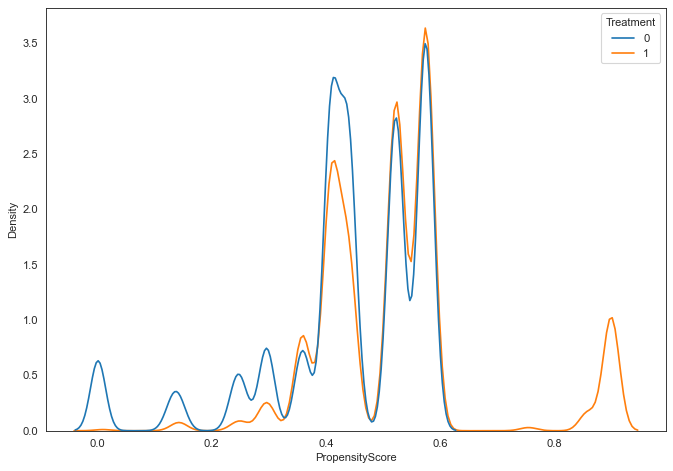

In [13]:
sns.set_style("white")
plt.figure(figsize=(10,7), dpi= 80)
sns.kdeplot(dataset['PropensityScore'], hue = dataset['Treatment'])

# * MSM: `Treatment` = 0
# * EPC: `Treatment` = 1

## Match Process

### Separating EPC data from MSM data

In [14]:
epc_df = dataset.loc[dataset.Treatment==1].reset_index(drop=True)
msm_df = dataset.loc[dataset.Treatment==0].reset_index(drop=True)

### Closest neighbors

#### Defining the number of neighbors

In [15]:
n_neighbors = 200  # number of neighbors to be stored for each hid in MSM data

#### Creating a list of closest neighbors (index and distance)

In [16]:
# create the neighbors object (p=2 means Euclidean distance)
knn = NearestNeighbors(n_neighbors=n_neighbors, p=2).fit(epc_df[['PropensityScore']])

# for each household in MSM dataframe, find the nearest EPC neighbors
distances, indices = knn.kneighbors(msm_df[['PropensityScore']])

### Matching Process overview

![Matching Process](figures/matching_process.png)

#### Weight function

A step-like function is going to be used as weight function. The weight function, $W$,  is defined as:

$$
W(\Delta P_{i,j}) = N -  \dfrac{\Delta P_{i,j}}{\Delta P_{i,n}}(N-M),
$$

where:

* $\Delta P_{i,j}$: Propensity Score difference between the MSM household $i$ and the EPC neighbor $j$ ($ 1 \le j \le n$)
* $\Delta P_{i,n}$: Propensity Score difference between the MSM household $i$ and the EPC neighbor $n$
* $n$: The number of neighbors (n_neighbors).
* N: Value of the highest desired weight. Here $N=100$.
* M: Value of the lowest desired weight. Here $M=5$.

> equal Propensity Score differences receive the same weight

##### Weight function example - MSM household id=4

Text(0, 0.5, 'Wheight')

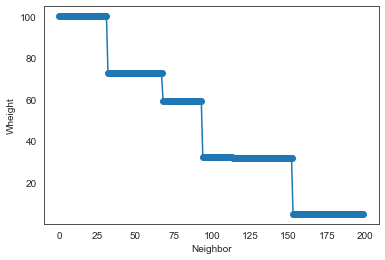

In [17]:
import numpy as np

i = 4  # MSM household id
N = 100  # max weight value
M = 5  # min weight values

delta_Pij = distances[i]
delta_Pin = distances[i][-1]

weight = N-((delta_Pij/delta_Pin)*(N-M))


x = np.arange(0, n_neighbors)
plt.plot(x,weight, 'o-')
plt.xlabel('Neighbor')
plt.ylabel('Wheight')

### Defining Matching Function

In [18]:
def get_matches(distances, indices):
    pairs = []
    for indexMSM, candidatesEPC in  enumerate(indices):
        is_zero = np.flatnonzero(distances[indexMSM]==0)
        if is_zero.size < n_neighbors:
            weight = (100-(distances[indexMSM]/distances[indexMSM][-1]*95))
            indexEPC = choices(candidatesEPC, weights=weight)[0] # random.choices not supported by numba
        else:
            indexEPC = choices(candidatesEPC)[0] # random.choices not supported by numba
        
        
        pairs.append([indexMSM, indexEPC])
    return(pairs)

### Get matched pairs

In [19]:
pairs = get_matches(distances, indices)

#### Add matched EPC id in MSM dataframe

In [20]:
matches = pd.DataFrame(pairs)
msm_df["EPCid"] = matches[1]
del matches, pairs

### Get EPC information

In [21]:
msm_df.drop(["tenure", 
             "Treatment", 
             "FLOOR_AREA", 
             "MAINHEAT_DESCRIPTION",
             "ACCOM_AGE",
             "Area_factor",
             "PropensityScore",], axis=1, inplace=True)
msm_df.head()

,HID,Area,LC4402_C_TYPACCOM,QS420_CELL,LC4402_C_TENHUK11,LC4408_C_AHTHUK11,CommunalSize,LC4404_C_SIZHUK11,LC4404_C_ROOMS,LC4405EW_C_BEDROOMS,LC4408EW_C_PPBROOMHEW11,LC4402_C_CENHEATHUK11,LC4605_C_NSSEC,LC4202_C_ETHHUK11,LC4202_C_CARSNO,HRPID,FILLED,EPCid
0,0.0,E00010088,3.0,-2.0,3.0,3.0,-2.0,2.0,4.0,2.0,-1.0,2.0,2.0,2.0,2.0,254841.0,True,44663
1,1.0,E00010222,2.0,-2.0,5.0,1.0,-2.0,1.0,3.0,1.0,-1.0,2.0,9.0,7.0,1.0,269214.0,True,25806
2,2.0,E00010300,5.0,-2.0,6.0,2.0,-2.0,4.0,6.0,4.0,-1.0,2.0,4.0,4.0,1.0,206340.0,False,85419
3,3.0,E00010394,-2.0,-2.0,-1.0,-1.0,-2.0,0.0,1.0,1.0,-1.0,2.0,-1.0,-1.0,1.0,-1.0,False,72919
4,4.0,E00010345,5.0,-2.0,6.0,3.0,-2.0,2.0,4.0,1.0,-1.0,2.0,5.0,4.0,1.0,258891.0,True,8872


In [22]:
columns = ['FLOOR_AREA', 'MAINHEAT_DESCRIPTION', 'ACCOM_AGE']
epc_df = epc_df[columns].copy()
epc_df['EPCid'] = epc_df.index

In [23]:
msm_df = pd.merge(msm_df, epc_df, on='EPCid',how='left')
msm_df.head()

,HID,Area,LC4402_C_TYPACCOM,QS420_CELL,LC4402_C_TENHUK11,LC4408_C_AHTHUK11,CommunalSize,LC4404_C_SIZHUK11,LC4404_C_ROOMS,LC4405EW_C_BEDROOMS,...,LC4402_C_CENHEATHUK11,LC4605_C_NSSEC,LC4202_C_ETHHUK11,LC4202_C_CARSNO,HRPID,FILLED,EPCid,FLOOR_AREA,MAINHEAT_DESCRIPTION,ACCOM_AGE
0,0.0,E00010088,3.0,-2.0,3.0,3.0,-2.0,2.0,4.0,2.0,...,2.0,2.0,2.0,2.0,254841.0,True,44663,13.0,"Boiler and radiators, mains gas",1.0
1,1.0,E00010222,2.0,-2.0,5.0,1.0,-2.0,1.0,3.0,1.0,...,2.0,9.0,7.0,1.0,269214.0,True,25806,13.0,"Boiler and radiators, mains gas",1.0
2,2.0,E00010300,5.0,-2.0,6.0,2.0,-2.0,4.0,6.0,4.0,...,2.0,4.0,4.0,1.0,206340.0,False,85419,1.0,Electric storage heaters,1.0
3,3.0,E00010394,-2.0,-2.0,-1.0,-1.0,-2.0,0.0,1.0,1.0,...,2.0,-1.0,-1.0,1.0,-1.0,False,72919,4.0,"Boiler and radiators, mains gas",6.0
4,4.0,E00010345,5.0,-2.0,6.0,3.0,-2.0,2.0,4.0,1.0,...,2.0,5.0,4.0,1.0,258891.0,True,8872,1.0,Community scheme,1.0


## Internal validation

### Floor area distribution

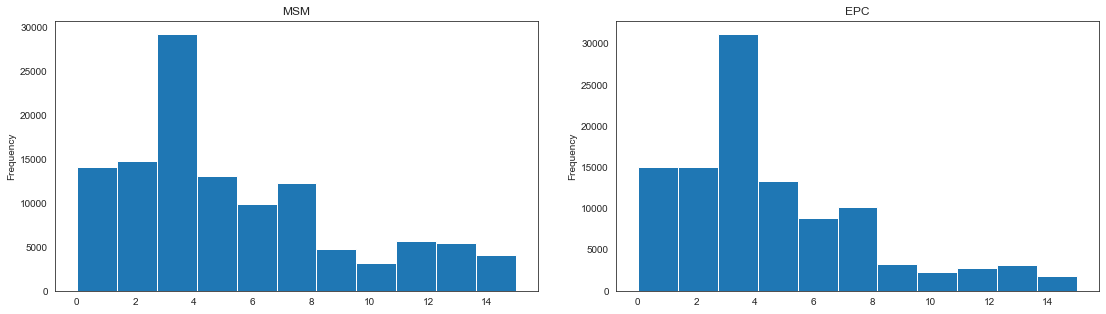

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

msm_df.FLOOR_AREA.plot(kind='hist', ax=ax[0], title="MSM", bins=11)
epc_df.FLOOR_AREA.plot(kind='hist', ax=ax[1], title="EPC", bins=11)

fig.tight_layout(pad=3.0)

### Accommodation age distribution

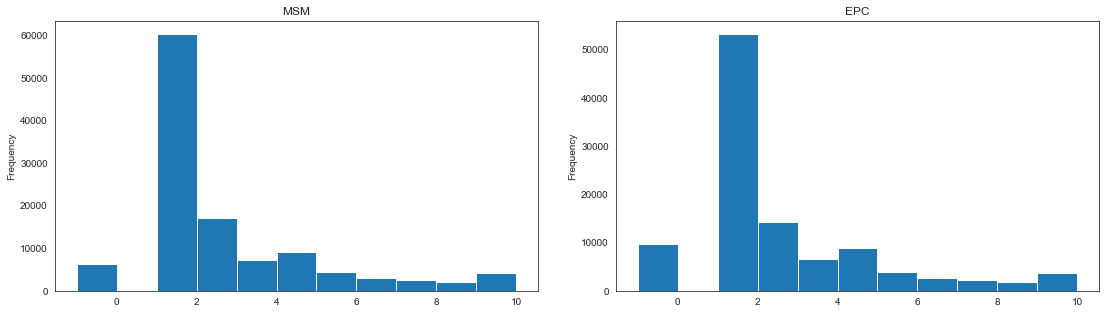

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

msm_df.ACCOM_AGE.plot(kind='hist', ax=ax[0], title="MSM", bins=11)
epc_df.ACCOM_AGE.plot(kind='hist', ax=ax[1], title="EPC", bins=11)
fig.tight_layout(pad=3.0)

In [27]:
list_df_names = ['msm_E09000014_epc.csv']
list_df = [msm_df]
csv_name = 'data/msm_england_epc.zip'
with zipfile.ZipFile(csv_name, 'w') as csv_zip:
    for i in range(len(list_df_names)):
        csv_zip.writestr(list_df_names[i], list_df[i].to_csv(index = False, header=True))

## Final comments

* The `MAINHEAT_DESCRIPTION` column has different values just for `Haringey`. 
    * If we consider all Local Authorities this number exceeds 700 values, making it difficult to code. 
    * So far they are being passed literally.
    * The ideal is to create different categories and organize the data according to them.
    * Without the proper organization, it is impossible to carry out any kind of validation.